# 使用UNET進行圖像分割





---


# kaggle導入數據集的方法

In [108]:
# mkdir ~/.kaggle

In [109]:
# cp kaggle.json ~/.kaggle/

In [110]:
# ! chmod 600 ~/.kaggle/kaggle.json

In [111]:
# ! kaggle competitions download -c carvana-image-masking-challenge

In [112]:
# ! unzip carvana-image-masking-challenge.zip



---



# import train_mask,train dataset

In [113]:
! chmod 600 train_masks.zip

In [114]:
! chmod 600 train.zip

In [115]:
# !unzip trian_masks.zip

In [116]:
# !unzip train.zip

In [117]:
pip install imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [118]:
import cv2
import numpy as np
import imageio
from scipy import ndimage
from glob import glob
import zipfile

In [119]:
path_to_zip_file = "train.zip"
directory_to_extract_to = "./output/"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)
    
path_to_zip_file = "train_masks.zip"
directory_to_extract_to = "./output/"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [120]:
! pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-76iubh7j
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-76iubh7j


In [121]:
IMG_ROWS = 128
IMG_COLS = 128
SAMPLE = 1000

In [122]:
train_mask_paths  = sorted(glob("./output/train_masks/*.gif"))[:SAMPLE]


In [123]:
train_img_paths   = sorted(glob("./output/train/*.jpg"))[:SAMPLE]
test_img_paths = sorted(glob("./output/train/*.jpg"))[SAMPLE:2000]

In [124]:
train_img_paths   


['./output/train/00087a6bd4dc_01.jpg',
 './output/train/00087a6bd4dc_02.jpg',
 './output/train/00087a6bd4dc_03.jpg',
 './output/train/00087a6bd4dc_04.jpg',
 './output/train/00087a6bd4dc_05.jpg',
 './output/train/00087a6bd4dc_06.jpg',
 './output/train/00087a6bd4dc_07.jpg',
 './output/train/00087a6bd4dc_08.jpg',
 './output/train/00087a6bd4dc_09.jpg',
 './output/train/00087a6bd4dc_10.jpg',
 './output/train/00087a6bd4dc_11.jpg',
 './output/train/00087a6bd4dc_12.jpg',
 './output/train/00087a6bd4dc_13.jpg',
 './output/train/00087a6bd4dc_14.jpg',
 './output/train/00087a6bd4dc_15.jpg',
 './output/train/00087a6bd4dc_16.jpg',
 './output/train/02159e548029_01.jpg',
 './output/train/02159e548029_02.jpg',
 './output/train/02159e548029_03.jpg',
 './output/train/02159e548029_04.jpg',
 './output/train/02159e548029_05.jpg',
 './output/train/02159e548029_06.jpg',
 './output/train/02159e548029_07.jpg',
 './output/train/02159e548029_08.jpg',
 './output/train/02159e548029_09.jpg',
 './output/train/02159e54

In [125]:
train_imgs = np.array([cv2.resize(imageio.imread(path), (IMG_ROWS, IMG_COLS))
                        for path in train_img_paths])

train_imgs.shape

(1000, 128, 128, 3)

In [126]:
train_masks = np.array([cv2.resize(imageio.imread(path), (IMG_ROWS, IMG_COLS))
                        for path in train_mask_paths])
train_masks.shape

(1000, 128, 128)

In [127]:
test_imgs = np.array([cv2.resize(imageio.imread(path), (IMG_ROWS, IMG_COLS))
                        for path in test_img_paths])

test_imgs.shape

(1000, 128, 128, 3)

In [128]:
train_masks = train_masks.astype(np.float32)

In [129]:
train_masks[train_masks<=127] = 0.
train_masks[train_masks>127] = 1.
train_masks = np.reshape(train_masks, (*train_masks.shape, 1))

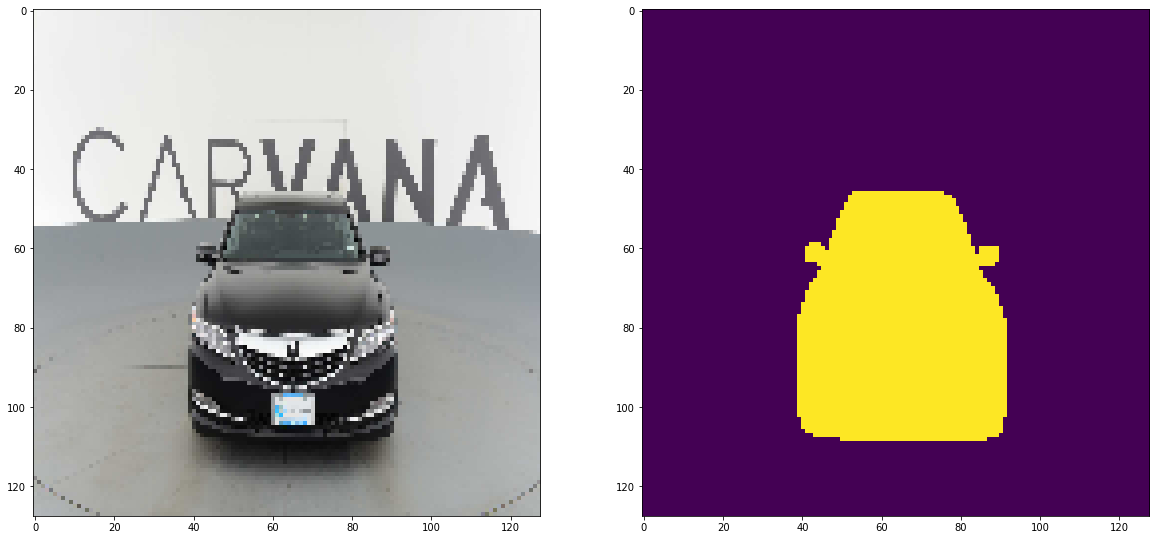

In [130]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(0, figsize=(20, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(train_imgs[0])
fig.add_subplot(1, 2, 2)
plt.imshow(np.squeeze(train_masks[0]))


# 定義模型

In [131]:
OUTPUT_CHANNELS = 3

In [132]:
import tensorflow as tf 
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# 使用这些层的激活设置
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# 创建特征提取模型
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [133]:
from tensorflow_examples.models.pix2pix import pix2pix

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [134]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[IMG_COLS, IMG_ROWS, 3])
  x = inputs

  # 在模型中降频取样
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # 升频取样然后建立跳跃连接
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # 这是模型的最后一层
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [135]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

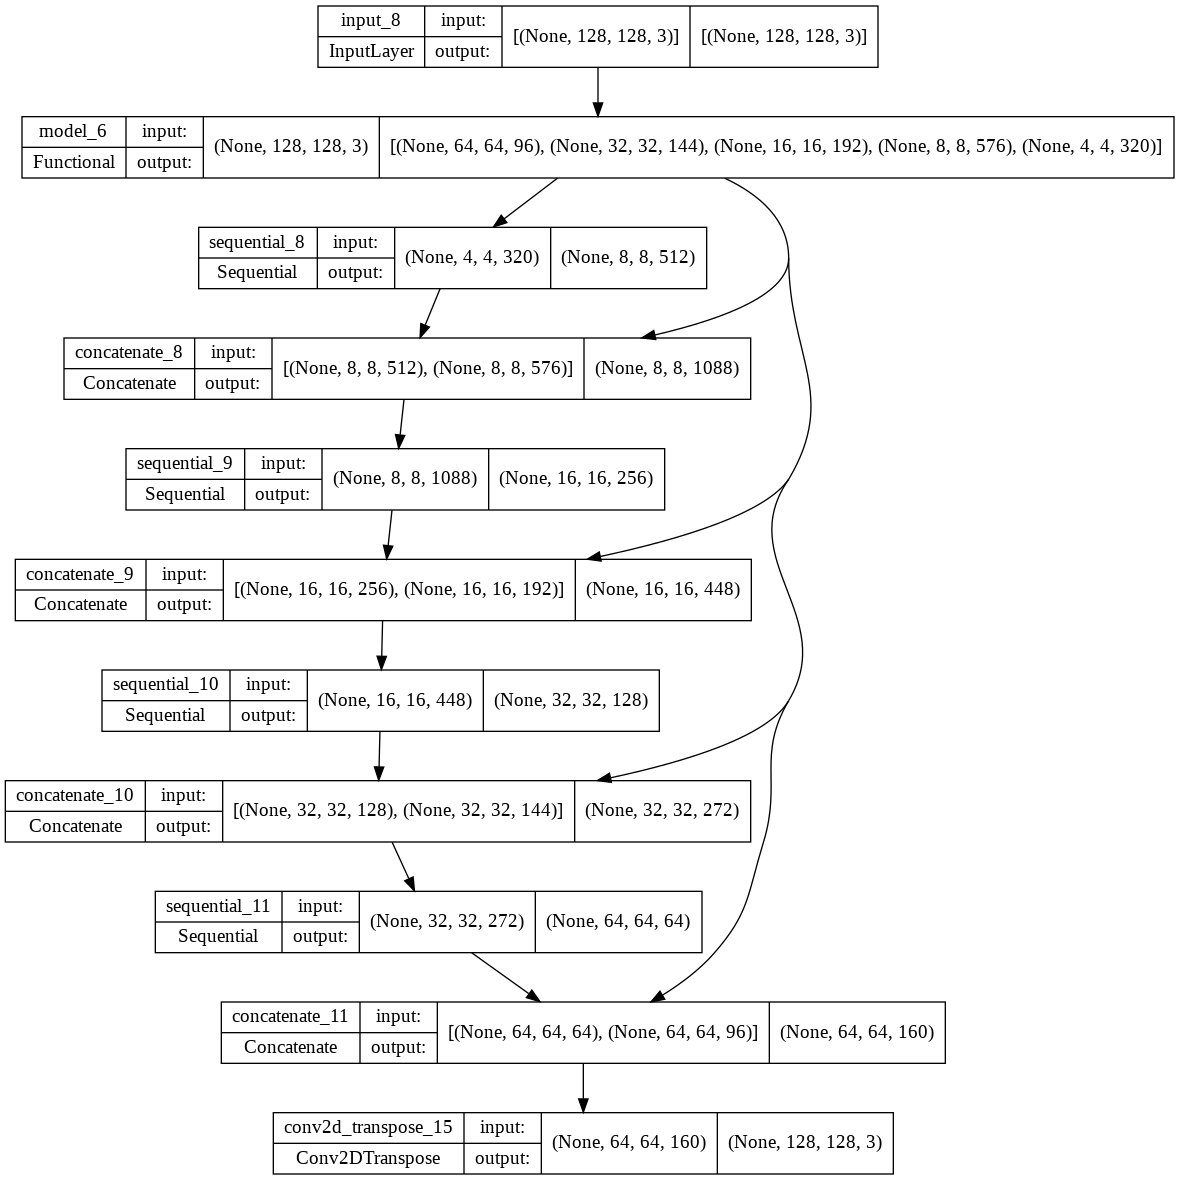

In [136]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [137]:
# def create_mask(pred_mask):
#   pred_mask = tf.math.argmax(pred_mask, axis=-1)
#   pred_mask = pred_mask[..., tf.newaxis]
#   return pred_mask[0]


In [138]:
# def show_predictions(dataset=None, num=1):
#   # 如果數據集有關鍵點的mask則顯示，否則就predict
#   # if dataset:
#   #   for image, mask in dataset.take(num):
#   #     pred_mask = model.predict(image)
#   #     display([image[0], mask[0], create_mask(pred_mask)])
#   # else:
#   # display([dataset[0],create_mask(model.predict(dataset[tf.newaxis, ...]))])
#   display([dataset[num],create_mask(model.predict(dataset[num]))])

In [139]:
EPOCHS = 10

model_history = model.fit(train_imgs,train_masks,
                          epochs=EPOCHS,
                          batch_size = 64,
                          validation_data=(train_imgs,train_masks))


Epoch 1/10
16/16 [==============================] - 7s 265ms/step - loss: 0.5950 - accuracy: 0.7486 - val_loss: 1.1556 - val_accuracy: 0.6679
Epoch 2/10
16/16 [==============================] - 3s 184ms/step - loss: 0.1645 - accuracy: 0.9427 - val_loss: 1.2499 - val_accuracy: 0.7173
Epoch 3/10
16/16 [==============================] - 3s 185ms/step - loss: 0.0936 - accuracy: 0.9681 - val_loss: 0.8695 - val_accuracy: 0.7919
Epoch 4/10
16/16 [==============================] - 3s 193ms/step - loss: 0.0726 - accuracy: 0.9742 - val_loss: 0.3258 - val_accuracy: 0.9026
Epoch 5/10
16/16 [==============================] - 3s 190ms/step - loss: 0.0615 - accuracy: 0.9776 - val_loss: 0.1464 - val_accuracy: 0.9499
Epoch 6/10
16/16 [==============================] - 3s 187ms/step - loss: 0.0548 - accuracy: 0.9798 - val_loss: 0.0777 - val_accuracy: 0.9715
Epoch 7/10
16/16 [==============================] - 3s 204ms/step - loss: 0.0495 - accuracy: 0.9815 - val_loss: 0.0531 - val_accuracy: 0.9801
Epoch 

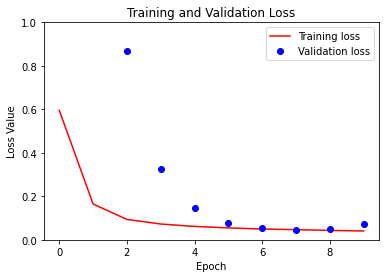

In [140]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [141]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_6 (Functional)           [(None, 64, 64, 96)  1841984     ['input_8[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

In [142]:
test_imgs[0].shape

(128, 128, 3)

In [143]:
# show_predictions(test_imgs,3)
test_imgs[0] = test_imgs[0][tf.newaxis, ...]


In [144]:
pred = model.predict(test_imgs[0][tf.newaxis, ...])
pred

array([[[[ 2.4624043e+00, -1.0027845e+00, -1.9517977e+00],
         [ 4.1627502e+00, -1.5748618e+00, -3.3222282e+00],
         [ 3.5149803e+00, -1.3856913e+00, -4.2382770e+00],
         ...,
         [ 4.6642981e+00, -1.4948895e+00, -2.5163827e+00],
         [ 3.4340522e+00, -2.1404366e+00, -4.5054679e+00],
         [ 3.8036978e+00, -6.9540673e-01, -2.6150162e+00]],

        [[ 3.9164121e+00,  3.4201527e-01, -2.2349606e+00],
         [ 4.0931406e+00, -1.3237399e+00, -4.3898273e+00],
         [ 7.8198109e+00, -4.6254275e-03, -4.4131994e+00],
         ...,
         [ 4.0709786e+00, -1.8079076e+00, -4.1527290e+00],
         [ 7.8965244e+00, -5.0083888e-01, -3.8431919e+00],
         [ 4.0119720e+00, -1.3751184e+00, -4.0573440e+00]],

        [[ 2.6859562e+00, -2.1303709e+00, -5.5452442e+00],
         [ 7.4085183e+00, -8.4118855e-01, -6.0857811e+00],
         [ 3.6196649e+00, -3.4306393e+00, -1.0773924e+01],
         ...,
         [ 7.0680819e+00, -1.0005920e+00, -4.0742183e+00],
         [